In [2]:
!pip install -U fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 12.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from fairlearn.metrics import selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.options.display.max_columns=500

/kaggle/input/loan-data/train.csv
/kaggle/input/loan-data/test.csv


This notebook serves as a primer on machine learning unfairness. 

We'll go through the following: 
* [0. What is fairness ?](#0)
* [1. Loading Data & EDA](#1)
    * [1.1. Gender and salary](#1.1.)
    * [1.2. Age and salary](#1.2.)
* [2. Evaluating Unfairness](#2)
* [3. Addressing Unfairness](#3)

<a id="0"></a>
# **<center><span style="color:#FF7B5F;">0. What is fairness? </span></center>**

In order to simplify things, we'll restrict the scope to binary classification. 

Usually, we'll call: 
- X: feature matrix
- Y: target
- A: Sensitive feature, usually one of the columns of X

--- 

For binary classification, two main definition of fairness exist: 
- __Demographic parity (also known as statistical parity)__: A classifier _h_ satisfies demographic parity under a distribution over _(X,A,Y)_ if its prediction h(X) is statistically independent of the sensitive feature _A_. This is equivalent to: $E[h(X)|A=a] = E[h(X)]$

- __Equalized odds__: A classifier h satisfies equalized odds under a distribution over _(X,A,Y)_ if its prediction h(X) is conditionally independent of the sensitive feature A given the label Y. This is equivalent to: $E[h(X)|A=a, Y=y] = E[h(X)| Y=y]$

--- 

In "simpler words": 
- __Demographic parity__: the prediction should be independent from the sensitive features (for instance independent from gender). It states that all categories from the protected feature should receive the positive outcome at the same rate (it plays on selection rate)
- __Equalized odds__: the prediction can be correlated to the sensitive feature, to the extent it is explained by the data we see

--- 

__Q__: OK, that's interesting, but why does it matter? And how can I use those mathematical concepts? 


__A__: Let's take two examples of features and then explain what type of fairness we want to have for this feature. Let's say you are the CEO of a very big company and want to build an algorithm which would give you the salary you should give to your employees based on performance indicators. 
Ideally you would look for something like: 
- Demographic Parity for gender: the salary prediction should be independent from the gender 
- Equalized Odds for Age: the salary prediction should not be independent from Age (you want to still pay more employees with more experience) but you still want to control that the salary so that you do not end up being too skewed → you don't want to end up in the situation where the algorithm exacerbates even more the inequalities (pays the youth even less and the elders even more)

<a id="1"></a>
# **<center><span style="color:#FF7B5F;">1. Loading data for Property Area & EDA </span></center>**

Let's begin by looking at the data and look at sensitive features (Property Area) to predict whether someone's loan got approved or not

In [36]:
dataset_path = '/kaggle/input/loan-data/'

data = pd.read_csv(dataset_path + 'train.csv')
X = pd.get_dummies(data, drop_first=True)
y = (data['Loan_Status'] == 'Y') * 1
area = data['Property_Area']

# Assuming X contains NaN values
X = X.dropna()
y = y[X.index]  # Match y with the indices of non-NaN rows in X
area = area[X.index]  # Similarly update 'area' if needed

df = pd.concat([X,pd.Series(y, name='Y')], axis=1)

In [37]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID_LP001003,Loan_ID_LP001005,Loan_ID_LP001006,Loan_ID_LP001008,Loan_ID_LP001011,Loan_ID_LP001013,Loan_ID_LP001014,Loan_ID_LP001018,Loan_ID_LP001020,Loan_ID_LP001024,Loan_ID_LP001027,Loan_ID_LP001028,Loan_ID_LP001029,Loan_ID_LP001030,Loan_ID_LP001032,Loan_ID_LP001034,Loan_ID_LP001036,Loan_ID_LP001038,Loan_ID_LP001041,Loan_ID_LP001043,Loan_ID_LP001046,Loan_ID_LP001047,Loan_ID_LP001050,Loan_ID_LP001052,Loan_ID_LP001066,Loan_ID_LP001068,Loan_ID_LP001073,Loan_ID_LP001086,Loan_ID_LP001087,Loan_ID_LP001091,Loan_ID_LP001095,Loan_ID_LP001097,Loan_ID_LP001098,Loan_ID_LP001100,Loan_ID_LP001106,Loan_ID_LP001109,Loan_ID_LP001112,Loan_ID_LP001114,Loan_ID_LP001116,Loan_ID_LP001119,Loan_ID_LP001120,Loan_ID_LP001123,Loan_ID_LP001131,Loan_ID_LP001136,Loan_ID_LP001137,Loan_ID_LP001138,Loan_ID_LP001144,Loan_ID_LP001146,Loan_ID_LP001151,Loan_ID_LP001155,Loan_ID_LP001157,Loan_ID_LP001164,Loan_ID_LP001179,Loan_ID_LP001186,Loan_ID_LP001194,Loan_ID_LP001195,Loan_ID_LP001197,Loan_ID_LP001198,Loan_ID_LP001199,Loan_ID_LP001205,Loan_ID_LP001206,Loan_ID_LP001207,Loan_ID_LP001213,Loan_ID_LP001222,Loan_ID_LP001225,Loan_ID_LP001228,Loan_ID_LP001233,Loan_ID_LP001238,Loan_ID_LP001241,Loan_ID_LP001243,Loan_ID_LP001245,Loan_ID_LP001248,Loan_ID_LP001250,Loan_ID_LP001253,Loan_ID_LP001255,Loan_ID_LP001256,Loan_ID_LP001259,Loan_ID_LP001263,Loan_ID_LP001264,Loan_ID_LP001265,Loan_ID_LP001266,Loan_ID_LP001267,Loan_ID_LP001273,Loan_ID_LP001275,Loan_ID_LP001279,Loan_ID_LP001280,Loan_ID_LP001282,Loan_ID_LP001289,Loan_ID_LP001310,Loan_ID_LP001316,Loan_ID_LP001318,Loan_ID_LP001319,Loan_ID_LP001322,Loan_ID_LP001325,Loan_ID_LP001326,Loan_ID_LP001327,Loan_ID_LP001333,Loan_ID_LP001334,Loan_ID_LP001343,Loan_ID_LP001345,Loan_ID_LP001349,Loan_ID_LP001350,Loan_ID_LP001356,Loan_ID_LP001357,Loan_ID_LP001367,Loan_ID_LP001369,Loan_ID_LP001370,Loan_ID_LP001379,Loan_ID_LP001384,Loan_ID_LP001385,Loan_ID_LP001387,Loan_ID_LP001391,Loan_ID_LP001392,Loan_ID_LP001398,Loan_ID_LP001401,Loan_ID_LP001404,Loan_ID_LP001405,Loan_ID_LP001421,Loan_ID_LP001422,Loan_ID_LP001426,Loan_ID_LP001430,Loan_ID_LP001431,Loan_ID_LP001432,Loan_ID_LP001439,Loan_ID_LP001443,Loan_ID_LP001448,Loan_ID_LP001449,Loan_ID_LP001451,Loan_ID_LP001465,Loan_ID_LP001469,Loan_ID_LP001473,Loan_ID_LP001478,Loan_ID_LP001482,Loan_ID_LP001487,Loan_ID_LP001488,Loan_ID_LP001489,Loan_ID_LP001491,Loan_ID_LP001492,Loan_ID_LP001493,Loan_ID_LP001497,Loan_ID_LP001498,Loan_ID_LP001504,Loan_ID_LP001507,Loan_ID_LP001508,Loan_ID_LP001514,Loan_ID_LP001516,Loan_ID_LP001518,Loan_ID_LP001519,Loan_ID_LP001520,Loan_ID_LP001528,Loan_ID_LP001529,Loan_ID_LP001531,Loan_ID_LP001532,Loan_ID_LP001535,Loan_ID_LP001536,Loan_ID_LP001541,Loan_ID_LP001543,Loan_ID_LP001546,Loan_ID_LP001552,Loan_ID_LP001560,Loan_ID_LP001562,Loan_ID_LP001565,Loan_ID_LP001570,Loan_ID_LP001572,Loan_ID_LP001574,Loan_ID_LP001577,Loan_ID_LP001578,Loan_ID_LP001579,Loan_ID_LP001580,Loan_ID_LP001581,Loan_ID_LP001585,Loan_ID_LP001586,Loan_ID_LP001594,Loan_ID_LP001603,Loan_ID_LP001606,Loan_ID_LP001608,Loan_ID_LP001610,Loan_ID_LP001616,Loan_ID_LP001630,Loan_ID_LP001633,Loan_ID_LP001634,Loan_ID_LP001636,Loan_ID_LP001637,Loan_ID_LP001639,Loan_ID_LP001640,Loan_ID_LP001641,Loan_ID_LP001643,Loan_ID_LP001644,Loan_ID_LP001647,Loan_ID_LP001653,Loan_ID_LP001656,Loan_ID_LP001657,Loan_ID_LP001658,Loan_ID_LP001664,Loan_ID_LP001665,Loan_ID_LP001666,Loan_ID_LP001669,Loan_ID_LP001671,Loan_ID_LP001673,Loan_ID_LP001674,Loan_ID_LP001677,Loan_ID_LP001682,Loan_ID_LP001688,Loan_ID_LP001691,Loan_ID_LP001692,Loan_ID_LP001693,Loan_ID_LP001698,Loan_ID_LP001699,Loan_ID_LP001702,Loan_ID_LP001708,Loan_ID_LP001711,Loan_ID_LP001713,Loan_ID_LP001715,Loan_ID_LP001716,Loan_ID_LP001720,Loan_ID_LP001722,Loan_ID_LP001726,Loan_ID_LP001732,Loan_ID_LP001734,Loan_ID_LP001736,Loan_ID_LP001743,Loan_ID_LP001744,Loan_ID_LP001749,Loan_ID_LP001750,Loan_ID_LP001751,Loan_ID_LP001754,Loan_ID_LP001758,Loan_ID_LP001760,Loan_ID_LP001761,Loan_ID_LP001765,Loan_ID_LP00

<a id="1.1."></a>
## **<center><span style="color:#FF7B5F;">1.1. Property Area and Loan Approval (Demographic Parity)</span></center>**

In [38]:
print(df.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_ID_LP001003',
       'Loan_ID_LP001005', 'Loan_ID_LP001006', 'Loan_ID_LP001008',
       'Loan_ID_LP001011',
       ...
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y', 'Y'],
      dtype='object', length=629)


In [39]:
pivot_property_area = pd.pivot_table(df,values='Y', index = 'Property_Area_Semiurban', aggfunc=['sum', 'count'])
pivot_property_area

,sum,count
,Y,Y
Property_Area_Semiurban,,
0,204,320
1,162,209


In [40]:
pivot_property_area['sum']/pivot_property_area['count']

,Y
Property_Area_Semiurban,
0,0.63750
1,0.77512


<Axes: title={'center': '% of loan approved for Semi-Urban vs Urban'}, xlabel='Property_Area_Semiurban'>

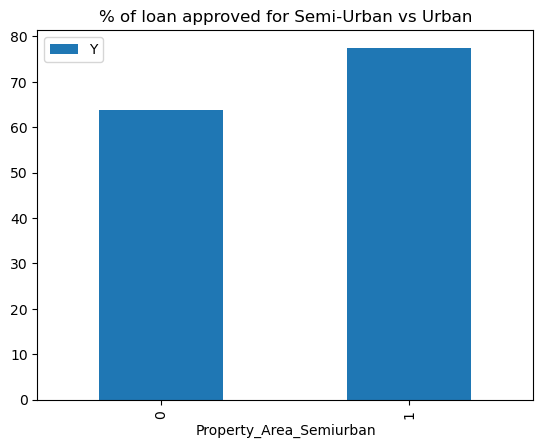

In [41]:
(pivot_property_area['sum']/pivot_property_area['count']*100).plot.bar(title='% of loan approved for Semi-Urban vs Urban')

We see that on the sample population, roughly 66% of female have loan approved vs 69% for male. 

This is a pattern that already exists in the data. We'd have to somehow change the algorithm if we want to change the situation and make salary independent from gender (this is Demographic Parity)

##=================

<a id="2"></a>
# **<center><span style="color:#FF7B5F;">2. Evaluating unfairness for Property Area</span></center>**

Let's build a simple sklearn classifier and fit it on the data. Then we'll evaluate how fair it is. 

In [42]:
classifier = GradientBoostingClassifier()
classifier.fit(X, y)

y_pred = classifier.predict(X)

In [44]:
gm = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred, sensitive_features=area)
print(gm.overall)
print(gm.by_group)

1.0
Property_Area
Rural        1.0
Semiurban    1.0
Urban        1.0
Name: accuracy_score, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Property_Area'>,
        <Axes: title={'center': 'precision'}, xlabel='Property_Area'>,
        <Axes: title={'center': 'recall'}, xlabel='Property_Area'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Property_Area'>,
        <Axes: xlabel='Property_Area'>, <Axes: xlabel='Property_Area'>],
       [<Axes: xlabel='Property_Area'>, <Axes: xlabel='Property_Area'>,
        <Axes: xlabel='Property_Area'>]], dtype=object)

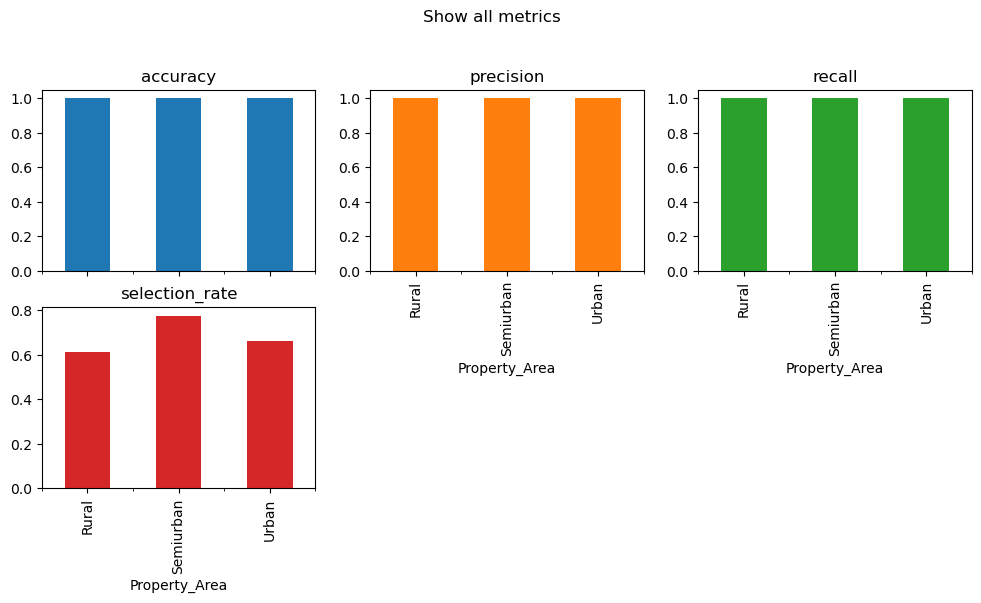

In [45]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred,
                           sensitive_features=area)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<Axes: title={'center': 'Selection Rate split by Area'}, xlabel='Property_Area'>

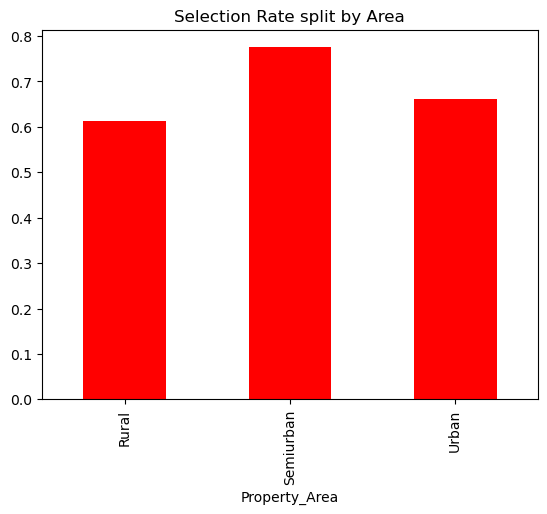

In [46]:
metric_frame.by_group['selection_rate'].plot.bar(color= 'r', title='Selection Rate split by Area')

<a id="3"></a>
# **<center><span style="color:#FF7B5F;">3. Addressing unfairness for Property Area</span></center>**

In [49]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y, sensitive_features=area)
y_pred_mitigated = mitigator.predict(X)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y, y_pred=y_pred_mitigated, sensitive_features=area)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.6710775047258979
Property_Area
Rural        0.638710
Semiurban    0.703349
Urban        0.660606
Name: selection_rate, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Property_Area'>,
        <Axes: title={'center': 'precision'}, xlabel='Property_Area'>,
        <Axes: title={'center': 'recall'}, xlabel='Property_Area'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Property_Area'>,
        <Axes: xlabel='Property_Area'>, <Axes: xlabel='Property_Area'>],
       [<Axes: xlabel='Property_Area'>, <Axes: xlabel='Property_Area'>,
        <Axes: xlabel='Property_Area'>]], dtype=object)

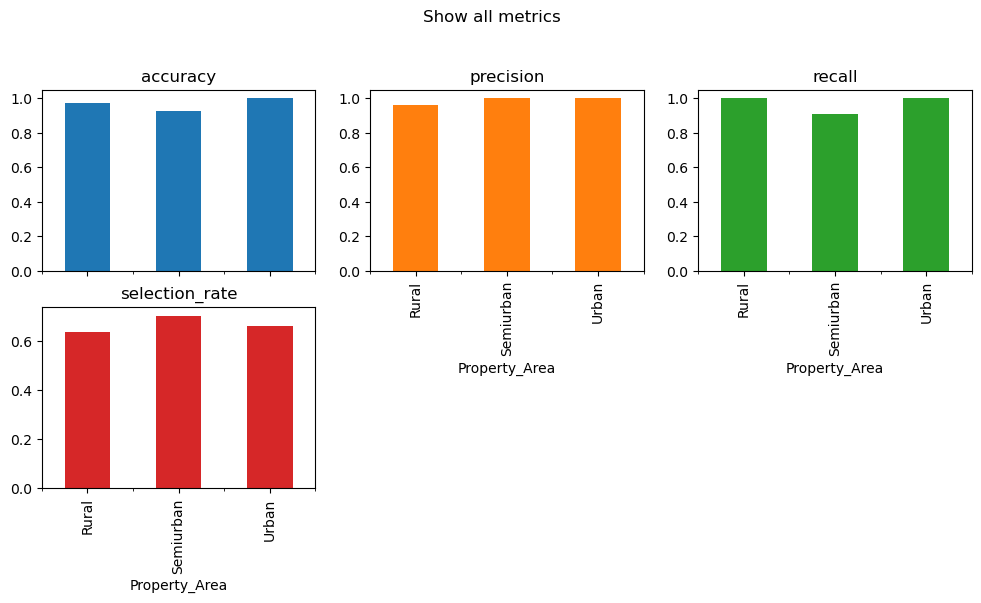

In [50]:
metric_frame_mitigated = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_mitigated,
                           sensitive_features=area)
metric_frame_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<Axes: title={'center': 'Selection Rate split by area'}, xlabel='Property_Area'>

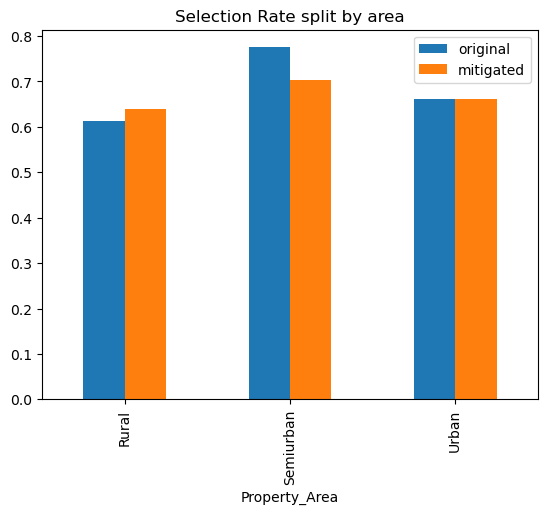

In [51]:
report = pd.DataFrame()
report['original'] = metric_frame.by_group['selection_rate']
report['mitigated'] = metric_frame_mitigated.by_group['selection_rate']
report.plot.bar(title='Selection Rate split by area')

We see that we defined the constraint and that the new predictions now achieve demographic parity the feature area.

Note that we have to choose two things in order to have a definition of fairness:

A definition of fairness (Demographic parity vs Equalized Odds)
A feature on which we want to achieve fairness
In the case of Demographic Parity, we mitigate our ML algo to have the same selection_rate in both groups (which means having the same number of positive predictions in both groups)

##============

<a id="1"></a>
# **<center><span style="color:#FF7B5F;">1. Loading data for Marriage & EDA </span></center>**

In [29]:
dataset_path = '/kaggle/input/loan-data/'

data = pd.read_csv(dataset_path + 'train.csv')
X = pd.get_dummies(data, drop_first=True)
y = (data['Loan_Status'] == 'Y') * 1
married = data['Married']

# Assuming X contains NaN values
X = X.dropna()
y = y[X.index]  # Match y with the indices of non-NaN rows in X
married_encoded = pd.get_dummies(married[X.index], prefix='Married', drop_first=True)  # Apply one-hot encoding to 'married'

df = pd.concat([X,pd.Series(y, name='Y')], axis=1)

In [30]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID_LP001003,Loan_ID_LP001005,Loan_ID_LP001006,Loan_ID_LP001008,Loan_ID_LP001011,Loan_ID_LP001013,Loan_ID_LP001014,Loan_ID_LP001018,Loan_ID_LP001020,Loan_ID_LP001024,Loan_ID_LP001027,Loan_ID_LP001028,Loan_ID_LP001029,Loan_ID_LP001030,Loan_ID_LP001032,Loan_ID_LP001034,Loan_ID_LP001036,Loan_ID_LP001038,Loan_ID_LP001041,Loan_ID_LP001043,Loan_ID_LP001046,Loan_ID_LP001047,Loan_ID_LP001050,Loan_ID_LP001052,Loan_ID_LP001066,Loan_ID_LP001068,Loan_ID_LP001073,Loan_ID_LP001086,Loan_ID_LP001087,Loan_ID_LP001091,Loan_ID_LP001095,Loan_ID_LP001097,Loan_ID_LP001098,Loan_ID_LP001100,Loan_ID_LP001106,Loan_ID_LP001109,Loan_ID_LP001112,Loan_ID_LP001114,Loan_ID_LP001116,Loan_ID_LP001119,Loan_ID_LP001120,Loan_ID_LP001123,Loan_ID_LP001131,Loan_ID_LP001136,Loan_ID_LP001137,Loan_ID_LP001138,Loan_ID_LP001144,Loan_ID_LP001146,Loan_ID_LP001151,Loan_ID_LP001155,Loan_ID_LP001157,Loan_ID_LP001164,Loan_ID_LP001179,Loan_ID_LP001186,Loan_ID_LP001194,Loan_ID_LP001195,Loan_ID_LP001197,Loan_ID_LP001198,Loan_ID_LP001199,Loan_ID_LP001205,Loan_ID_LP001206,Loan_ID_LP001207,Loan_ID_LP001213,Loan_ID_LP001222,Loan_ID_LP001225,Loan_ID_LP001228,Loan_ID_LP001233,Loan_ID_LP001238,Loan_ID_LP001241,Loan_ID_LP001243,Loan_ID_LP001245,Loan_ID_LP001248,Loan_ID_LP001250,Loan_ID_LP001253,Loan_ID_LP001255,Loan_ID_LP001256,Loan_ID_LP001259,Loan_ID_LP001263,Loan_ID_LP001264,Loan_ID_LP001265,Loan_ID_LP001266,Loan_ID_LP001267,Loan_ID_LP001273,Loan_ID_LP001275,Loan_ID_LP001279,Loan_ID_LP001280,Loan_ID_LP001282,Loan_ID_LP001289,Loan_ID_LP001310,Loan_ID_LP001316,Loan_ID_LP001318,Loan_ID_LP001319,Loan_ID_LP001322,Loan_ID_LP001325,Loan_ID_LP001326,Loan_ID_LP001327,Loan_ID_LP001333,Loan_ID_LP001334,Loan_ID_LP001343,Loan_ID_LP001345,Loan_ID_LP001349,Loan_ID_LP001350,Loan_ID_LP001356,Loan_ID_LP001357,Loan_ID_LP001367,Loan_ID_LP001369,Loan_ID_LP001370,Loan_ID_LP001379,Loan_ID_LP001384,Loan_ID_LP001385,Loan_ID_LP001387,Loan_ID_LP001391,Loan_ID_LP001392,Loan_ID_LP001398,Loan_ID_LP001401,Loan_ID_LP001404,Loan_ID_LP001405,Loan_ID_LP001421,Loan_ID_LP001422,Loan_ID_LP001426,Loan_ID_LP001430,Loan_ID_LP001431,Loan_ID_LP001432,Loan_ID_LP001439,Loan_ID_LP001443,Loan_ID_LP001448,Loan_ID_LP001449,Loan_ID_LP001451,Loan_ID_LP001465,Loan_ID_LP001469,Loan_ID_LP001473,Loan_ID_LP001478,Loan_ID_LP001482,Loan_ID_LP001487,Loan_ID_LP001488,Loan_ID_LP001489,Loan_ID_LP001491,Loan_ID_LP001492,Loan_ID_LP001493,Loan_ID_LP001497,Loan_ID_LP001498,Loan_ID_LP001504,Loan_ID_LP001507,Loan_ID_LP001508,Loan_ID_LP001514,Loan_ID_LP001516,Loan_ID_LP001518,Loan_ID_LP001519,Loan_ID_LP001520,Loan_ID_LP001528,Loan_ID_LP001529,Loan_ID_LP001531,Loan_ID_LP001532,Loan_ID_LP001535,Loan_ID_LP001536,Loan_ID_LP001541,Loan_ID_LP001543,Loan_ID_LP001546,Loan_ID_LP001552,Loan_ID_LP001560,Loan_ID_LP001562,Loan_ID_LP001565,Loan_ID_LP001570,Loan_ID_LP001572,Loan_ID_LP001574,Loan_ID_LP001577,Loan_ID_LP001578,Loan_ID_LP001579,Loan_ID_LP001580,Loan_ID_LP001581,Loan_ID_LP001585,Loan_ID_LP001586,Loan_ID_LP001594,Loan_ID_LP001603,Loan_ID_LP001606,Loan_ID_LP001608,Loan_ID_LP001610,Loan_ID_LP001616,Loan_ID_LP001630,Loan_ID_LP001633,Loan_ID_LP001634,Loan_ID_LP001636,Loan_ID_LP001637,Loan_ID_LP001639,Loan_ID_LP001640,Loan_ID_LP001641,Loan_ID_LP001643,Loan_ID_LP001644,Loan_ID_LP001647,Loan_ID_LP001653,Loan_ID_LP001656,Loan_ID_LP001657,Loan_ID_LP001658,Loan_ID_LP001664,Loan_ID_LP001665,Loan_ID_LP001666,Loan_ID_LP001669,Loan_ID_LP001671,Loan_ID_LP001673,Loan_ID_LP001674,Loan_ID_LP001677,Loan_ID_LP001682,Loan_ID_LP001688,Loan_ID_LP001691,Loan_ID_LP001692,Loan_ID_LP001693,Loan_ID_LP001698,Loan_ID_LP001699,Loan_ID_LP001702,Loan_ID_LP001708,Loan_ID_LP001711,Loan_ID_LP001713,Loan_ID_LP001715,Loan_ID_LP001716,Loan_ID_LP001720,Loan_ID_LP001722,Loan_ID_LP001726,Loan_ID_LP001732,Loan_ID_LP001734,Loan_ID_LP001736,Loan_ID_LP001743,Loan_ID_LP001744,Loan_ID_LP001749,Loan_ID_LP001750,Loan_ID_LP001751,Loan_ID_LP001754,Loan_ID_LP001758,Loan_ID_LP001760,Loan_ID_LP001761,Loan_ID_LP001765,Loan_ID_LP00

<a id="1.1."></a>
## **<center><span style="color:#FF7B5F;">1.1. Marriage status and Loan Approval (Demographic Parity)</span></center>**

In [31]:
print(df.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_ID_LP001003',
       'Loan_ID_LP001005', 'Loan_ID_LP001006', 'Loan_ID_LP001008',
       'Loan_ID_LP001011',
       ...
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y', 'Y'],
      dtype='object', length=629)


In [32]:
pivot_married = pd.pivot_table(df,values='Y', index = 'Married_Yes', aggfunc=['sum', 'count'])
pivot_married

,sum,count
,Y,Y
Married_Yes,,
0,121,190
1,245,339


In [33]:
pivot_married['sum']/pivot_married['count']

,Y
Married_Yes,
0,0.636842
1,0.722714


<Axes: title={'center': '% Loan approved for Married vs Un-Married'}, xlabel='Married_Yes'>

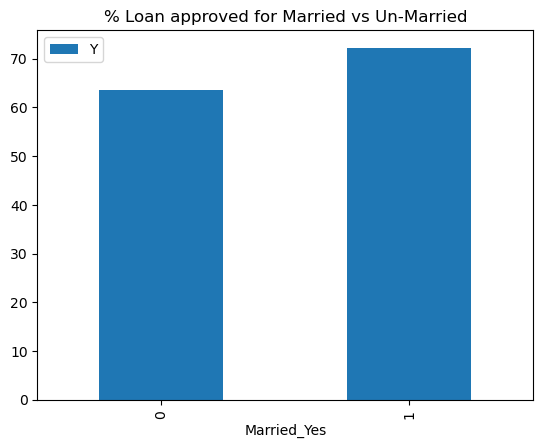

In [35]:
(pivot_married['sum']/pivot_married['count']*100).plot.bar(title='% Loan approved for Married vs Un-Married')

<a id="2"></a>
# **<center><span style="color:#FF7B5F;">2. Evaluating unfairness</span></center>**

In [36]:
classifier = GradientBoostingClassifier()
classifier.fit(X, y)

y_pred = classifier.predict(X)

In [37]:
gm = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred, sensitive_features=married_encoded)
print(gm.overall)
print(gm.by_group)

1.0
Married_Yes
0    1.0
1    1.0
Name: accuracy_score, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Married_Yes'>,
        <Axes: title={'center': 'precision'}, xlabel='Married_Yes'>,
        <Axes: title={'center': 'recall'}, xlabel='Married_Yes'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Married_Yes'>,
        <Axes: xlabel='Married_Yes'>, <Axes: xlabel='Married_Yes'>],
       [<Axes: xlabel='Married_Yes'>, <Axes: xlabel='Married_Yes'>,
        <Axes: xlabel='Married_Yes'>]], dtype=object)

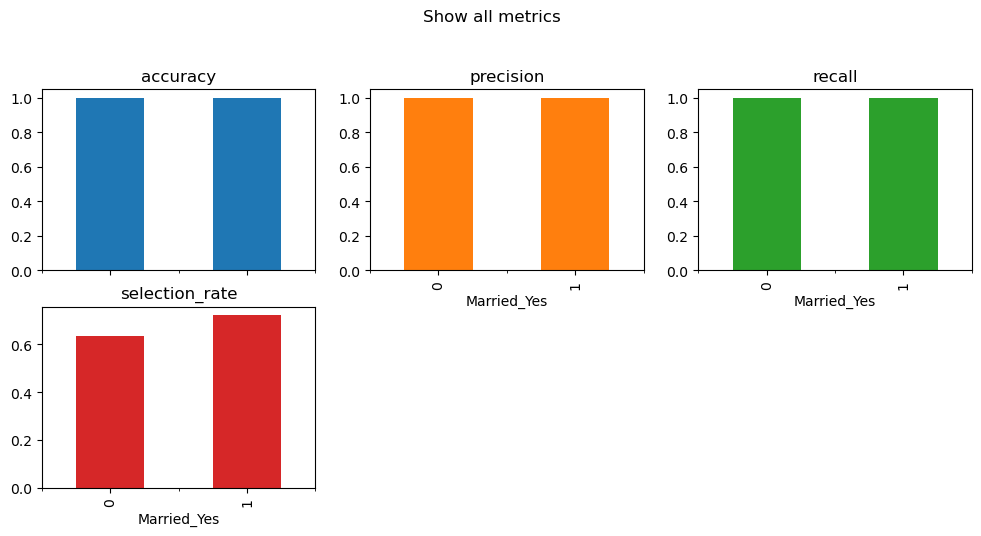

In [38]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred,
                           sensitive_features=married_encoded)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<a id="3"></a>
# **<center><span style="color:#FF7B5F;">3. Addressing unfairness for Married vs Un-Married</span></center>**

In [39]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y, sensitive_features=married_encoded)
y_pred_mitigated = mitigator.predict(X)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y, y_pred=y_pred_mitigated, sensitive_features=married_encoded)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.724007561436673
Married_Yes
0    0.726316
1    0.722714
Name: selection_rate, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Married_Yes'>,
        <Axes: title={'center': 'precision'}, xlabel='Married_Yes'>,
        <Axes: title={'center': 'recall'}, xlabel='Married_Yes'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Married_Yes'>,
        <Axes: xlabel='Married_Yes'>, <Axes: xlabel='Married_Yes'>],
       [<Axes: xlabel='Married_Yes'>, <Axes: xlabel='Married_Yes'>,
        <Axes: xlabel='Married_Yes'>]], dtype=object)

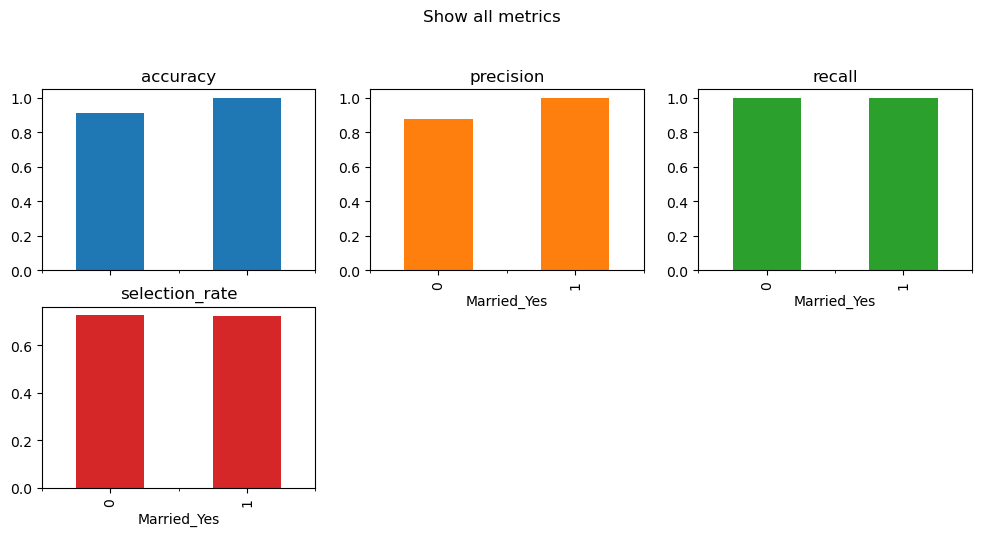

In [41]:
metric_frame_mitigated = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_mitigated,
                           sensitive_features=married_encoded)
metric_frame_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<Axes: title={'center': 'Selection Rate split by sex'}, xlabel='Married_Yes'>

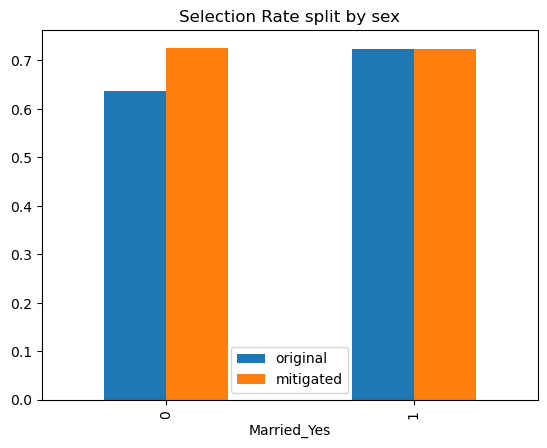

In [42]:
report = pd.DataFrame()
report['original'] = metric_frame.by_group['selection_rate']
report['mitigated'] = metric_frame_mitigated.by_group['selection_rate']
report.plot.bar(title='Selection Rate split by sex')

We see that we defined the constraint and that the new predictions now achieve demographic parity the feature marriage.

Note that we have to choose two things in order to have a definition of fairness:

A definition of fairness (Demographic parity vs Equalized Odds)
A feature on which we want to achieve fairness
In the case of Demographic Parity, we mitigate our ML algo to have the same selection_rate in both groups (which means having the same number of positive predictions in both groups)

##-----------

<a id="1"></a>
# **<center><span style="color:#FF7B5F;">1. Loading data for Dependents & EDA </span></center>**

In [3]:
dataset_path = '/kaggle/input/loan-data/'

data = pd.read_csv(dataset_path + 'train.csv')
X = pd.get_dummies(data, drop_first=True)
y = (data['Loan_Status'] == 'Y') * 1
dependents = data['Dependents']

# Assuming X contains NaN values
X = X.dropna()
y = y[X.index]  # Match y with the indices of non-NaN rows in X
dependents_encoded = pd.get_dummies(dependents[X.index], prefix='Dependents', drop_first=True)  # Apply one-hot encoding to 'dependents'

df = pd.concat([X,pd.Series(y, name='Y')], axis=1)

In [4]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID_LP001003,Loan_ID_LP001005,Loan_ID_LP001006,Loan_ID_LP001008,Loan_ID_LP001011,Loan_ID_LP001013,Loan_ID_LP001014,Loan_ID_LP001018,Loan_ID_LP001020,Loan_ID_LP001024,Loan_ID_LP001027,Loan_ID_LP001028,Loan_ID_LP001029,Loan_ID_LP001030,Loan_ID_LP001032,Loan_ID_LP001034,Loan_ID_LP001036,Loan_ID_LP001038,Loan_ID_LP001041,Loan_ID_LP001043,Loan_ID_LP001046,Loan_ID_LP001047,Loan_ID_LP001050,Loan_ID_LP001052,Loan_ID_LP001066,Loan_ID_LP001068,Loan_ID_LP001073,Loan_ID_LP001086,Loan_ID_LP001087,Loan_ID_LP001091,Loan_ID_LP001095,Loan_ID_LP001097,Loan_ID_LP001098,Loan_ID_LP001100,Loan_ID_LP001106,Loan_ID_LP001109,Loan_ID_LP001112,Loan_ID_LP001114,Loan_ID_LP001116,Loan_ID_LP001119,Loan_ID_LP001120,Loan_ID_LP001123,Loan_ID_LP001131,Loan_ID_LP001136,Loan_ID_LP001137,Loan_ID_LP001138,Loan_ID_LP001144,Loan_ID_LP001146,Loan_ID_LP001151,Loan_ID_LP001155,Loan_ID_LP001157,Loan_ID_LP001164,Loan_ID_LP001179,Loan_ID_LP001186,Loan_ID_LP001194,Loan_ID_LP001195,Loan_ID_LP001197,Loan_ID_LP001198,Loan_ID_LP001199,Loan_ID_LP001205,Loan_ID_LP001206,Loan_ID_LP001207,Loan_ID_LP001213,Loan_ID_LP001222,Loan_ID_LP001225,Loan_ID_LP001228,Loan_ID_LP001233,Loan_ID_LP001238,Loan_ID_LP001241,Loan_ID_LP001243,Loan_ID_LP001245,Loan_ID_LP001248,Loan_ID_LP001250,Loan_ID_LP001253,Loan_ID_LP001255,Loan_ID_LP001256,Loan_ID_LP001259,Loan_ID_LP001263,Loan_ID_LP001264,Loan_ID_LP001265,Loan_ID_LP001266,Loan_ID_LP001267,Loan_ID_LP001273,Loan_ID_LP001275,Loan_ID_LP001279,Loan_ID_LP001280,Loan_ID_LP001282,Loan_ID_LP001289,Loan_ID_LP001310,Loan_ID_LP001316,Loan_ID_LP001318,Loan_ID_LP001319,Loan_ID_LP001322,Loan_ID_LP001325,Loan_ID_LP001326,Loan_ID_LP001327,Loan_ID_LP001333,Loan_ID_LP001334,Loan_ID_LP001343,Loan_ID_LP001345,Loan_ID_LP001349,Loan_ID_LP001350,Loan_ID_LP001356,Loan_ID_LP001357,Loan_ID_LP001367,Loan_ID_LP001369,Loan_ID_LP001370,Loan_ID_LP001379,Loan_ID_LP001384,Loan_ID_LP001385,Loan_ID_LP001387,Loan_ID_LP001391,Loan_ID_LP001392,Loan_ID_LP001398,Loan_ID_LP001401,Loan_ID_LP001404,Loan_ID_LP001405,Loan_ID_LP001421,Loan_ID_LP001422,Loan_ID_LP001426,Loan_ID_LP001430,Loan_ID_LP001431,Loan_ID_LP001432,Loan_ID_LP001439,Loan_ID_LP001443,Loan_ID_LP001448,Loan_ID_LP001449,Loan_ID_LP001451,Loan_ID_LP001465,Loan_ID_LP001469,Loan_ID_LP001473,Loan_ID_LP001478,Loan_ID_LP001482,Loan_ID_LP001487,Loan_ID_LP001488,Loan_ID_LP001489,Loan_ID_LP001491,Loan_ID_LP001492,Loan_ID_LP001493,Loan_ID_LP001497,Loan_ID_LP001498,Loan_ID_LP001504,Loan_ID_LP001507,Loan_ID_LP001508,Loan_ID_LP001514,Loan_ID_LP001516,Loan_ID_LP001518,Loan_ID_LP001519,Loan_ID_LP001520,Loan_ID_LP001528,Loan_ID_LP001529,Loan_ID_LP001531,Loan_ID_LP001532,Loan_ID_LP001535,Loan_ID_LP001536,Loan_ID_LP001541,Loan_ID_LP001543,Loan_ID_LP001546,Loan_ID_LP001552,Loan_ID_LP001560,Loan_ID_LP001562,Loan_ID_LP001565,Loan_ID_LP001570,Loan_ID_LP001572,Loan_ID_LP001574,Loan_ID_LP001577,Loan_ID_LP001578,Loan_ID_LP001579,Loan_ID_LP001580,Loan_ID_LP001581,Loan_ID_LP001585,Loan_ID_LP001586,Loan_ID_LP001594,Loan_ID_LP001603,Loan_ID_LP001606,Loan_ID_LP001608,Loan_ID_LP001610,Loan_ID_LP001616,Loan_ID_LP001630,Loan_ID_LP001633,Loan_ID_LP001634,Loan_ID_LP001636,Loan_ID_LP001637,Loan_ID_LP001639,Loan_ID_LP001640,Loan_ID_LP001641,Loan_ID_LP001643,Loan_ID_LP001644,Loan_ID_LP001647,Loan_ID_LP001653,Loan_ID_LP001656,Loan_ID_LP001657,Loan_ID_LP001658,Loan_ID_LP001664,Loan_ID_LP001665,Loan_ID_LP001666,Loan_ID_LP001669,Loan_ID_LP001671,Loan_ID_LP001673,Loan_ID_LP001674,Loan_ID_LP001677,Loan_ID_LP001682,Loan_ID_LP001688,Loan_ID_LP001691,Loan_ID_LP001692,Loan_ID_LP001693,Loan_ID_LP001698,Loan_ID_LP001699,Loan_ID_LP001702,Loan_ID_LP001708,Loan_ID_LP001711,Loan_ID_LP001713,Loan_ID_LP001715,Loan_ID_LP001716,Loan_ID_LP001720,Loan_ID_LP001722,Loan_ID_LP001726,Loan_ID_LP001732,Loan_ID_LP001734,Loan_ID_LP001736,Loan_ID_LP001743,Loan_ID_LP001744,Loan_ID_LP001749,Loan_ID_LP001750,Loan_ID_LP001751,Loan_ID_LP001754,Loan_ID_LP001758,Loan_ID_LP001760,Loan_ID_LP001761,Loan_ID_LP001765,Loan_ID_LP00

<a id="1.1."></a>
## **<center><span style="color:#FF7B5F;">1.1. Dependents and Loan Approval (Demographic Parity)</span></center>**

In [5]:
print(df.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_ID_LP001003',
       'Loan_ID_LP001005', 'Loan_ID_LP001006', 'Loan_ID_LP001008',
       'Loan_ID_LP001011',
       ...
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y', 'Y'],
      dtype='object', length=629)


In [15]:
pivot_dependents = pd.pivot_table(df,values='Y', index = 'Dependents_3+', aggfunc=['sum', 'count'])
pivot_dependents

,sum,count
,Y,Y
Dependents_3+,,
0,334,484
1,32,45


In [16]:
pivot_dependents['sum']/pivot_dependents['count']

,Y
Dependents_3+,
0,0.690083
1,0.711111


<Axes: title={'center': '% Loan approved for Number of Dependents'}, xlabel='Dependents_3+'>

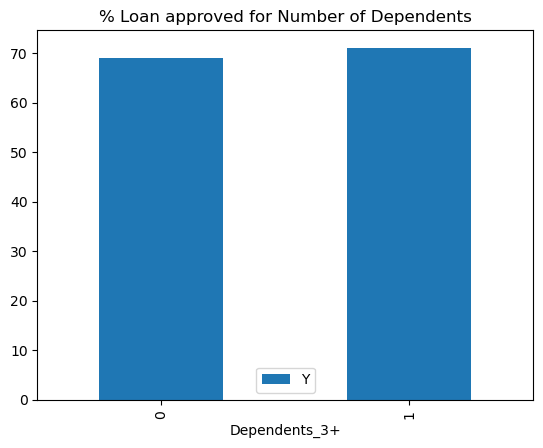

In [17]:
(pivot_dependents['sum']/pivot_dependents['count']*100).plot.bar(title='% Loan approved for Number of Dependents')

<a id="2"></a>
# **<center><span style="color:#FF7B5F;">2. Evaluating unfairness</span></center>**

In [18]:
classifier = GradientBoostingClassifier()
classifier.fit(X, y)

y_pred = classifier.predict(X)

In [20]:
gm = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred, sensitive_features=dependents_encoded)
print(gm.overall)
print(gm.by_group)

1.0
Dependents_1  Dependents_2  Dependents_3+
0             0             0                1.0
                            1                1.0
              1             0                1.0
                            1                NaN
1             0             0                1.0
                            1                NaN
              1             0                NaN
                            1                NaN
Name: accuracy_score, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: title={'center': 'precision'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: title={'center': 'recall'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>],
       [<Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>]],
      dtype=object)

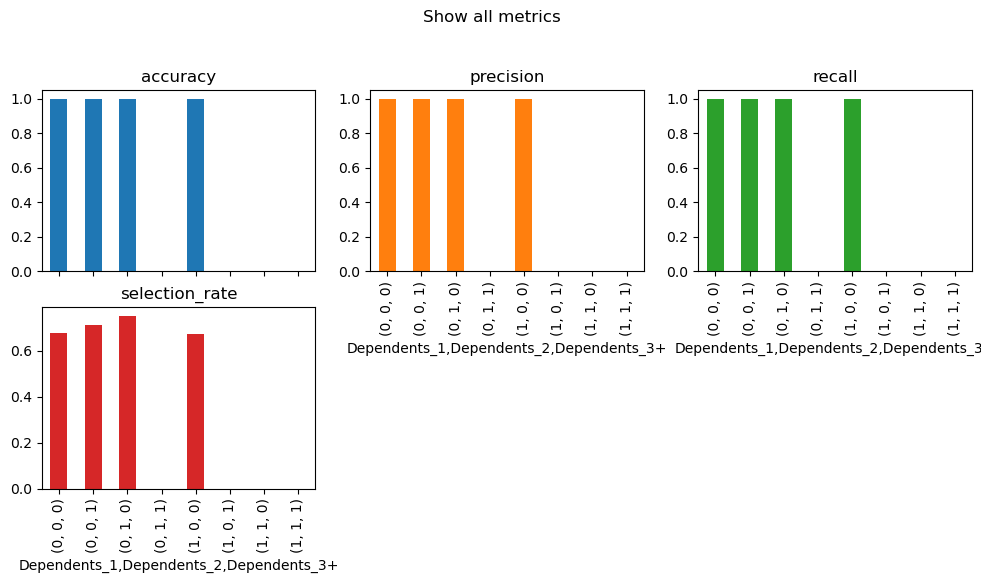

In [22]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred,
                           sensitive_features=dependents_encoded)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<a id="3"></a>
# **<center><span style="color:#FF7B5F;">3. Addressing unfairness for Number of Dependents</span></center>**

In [23]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y, sensitive_features=dependents_encoded)
y_pred_mitigated = mitigator.predict(X)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y, y_pred=y_pred_mitigated, sensitive_features=dependents_encoded)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.6805293005671077
Dependents_1  Dependents_2  Dependents_3+
0             0             0                0.677524
                            1                0.711111
              1             0                0.684783
                            1                     NaN
1             0             0                0.670588
                            1                     NaN
              1             0                     NaN
                            1                     NaN
Name: selection_rate, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: title={'center': 'precision'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: title={'center': 'recall'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>],
       [<Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>,
        <Axes: xlabel='Dependents_1,Dependents_2,Dependents_3+'>]],
      dtype=object)

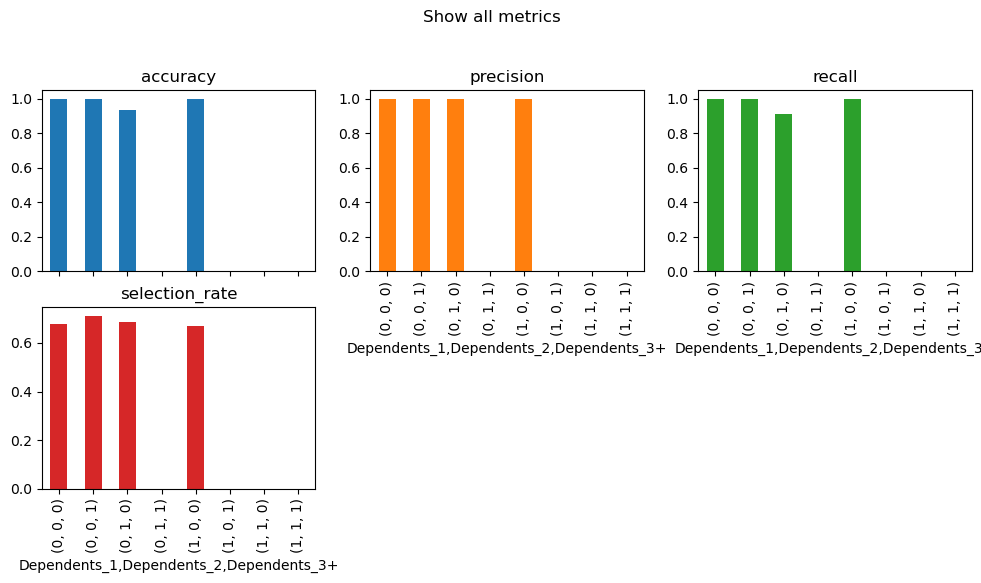

In [24]:
metric_frame_mitigated = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_mitigated,
                           sensitive_features=dependents_encoded)
metric_frame_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<Axes: title={'center': 'Selection Rate split by dependents'}, xlabel='Dependents_1,Dependents_2,Dependents_3+'>

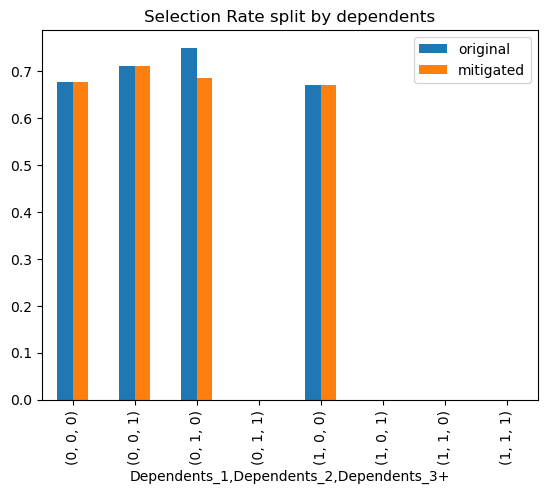

In [25]:
report = pd.DataFrame()
report['original'] = metric_frame.by_group['selection_rate']
report['mitigated'] = metric_frame_mitigated.by_group['selection_rate']
report.plot.bar(title='Selection Rate split by dependents')

##==========

<a id="1"></a>
# **<center><span style="color:#FF7B5F;">1. Loading data for Gender & EDA </span></center>**

In [14]:
dataset_path = '/kaggle/input/loan-data/'

data = pd.read_csv(dataset_path + 'train.csv')
X = pd.get_dummies(data, drop_first=True)
y = (data['Loan_Status'] == 'Y') * 1
gender = data['Gender']

# Assuming X contains NaN values
X = X.dropna()
y = y[X.index]  # Match y with the indices of non-NaN rows in X
gender_encoded = pd.get_dummies(dependents[X.index], prefix='Gender', drop_first=True)  # Apply one-hot encoding to 'gender'

df = pd.concat([X,pd.Series(y, name='Y')], axis=1)

In [15]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID_LP001003,Loan_ID_LP001005,Loan_ID_LP001006,Loan_ID_LP001008,Loan_ID_LP001011,Loan_ID_LP001013,Loan_ID_LP001014,Loan_ID_LP001018,Loan_ID_LP001020,Loan_ID_LP001024,Loan_ID_LP001027,Loan_ID_LP001028,Loan_ID_LP001029,Loan_ID_LP001030,Loan_ID_LP001032,Loan_ID_LP001034,Loan_ID_LP001036,Loan_ID_LP001038,Loan_ID_LP001041,Loan_ID_LP001043,Loan_ID_LP001046,Loan_ID_LP001047,Loan_ID_LP001050,Loan_ID_LP001052,Loan_ID_LP001066,Loan_ID_LP001068,Loan_ID_LP001073,Loan_ID_LP001086,Loan_ID_LP001087,Loan_ID_LP001091,Loan_ID_LP001095,Loan_ID_LP001097,Loan_ID_LP001098,Loan_ID_LP001100,Loan_ID_LP001106,Loan_ID_LP001109,Loan_ID_LP001112,Loan_ID_LP001114,Loan_ID_LP001116,Loan_ID_LP001119,Loan_ID_LP001120,Loan_ID_LP001123,Loan_ID_LP001131,Loan_ID_LP001136,Loan_ID_LP001137,Loan_ID_LP001138,Loan_ID_LP001144,Loan_ID_LP001146,Loan_ID_LP001151,Loan_ID_LP001155,Loan_ID_LP001157,Loan_ID_LP001164,Loan_ID_LP001179,Loan_ID_LP001186,Loan_ID_LP001194,Loan_ID_LP001195,Loan_ID_LP001197,Loan_ID_LP001198,Loan_ID_LP001199,Loan_ID_LP001205,Loan_ID_LP001206,Loan_ID_LP001207,Loan_ID_LP001213,Loan_ID_LP001222,Loan_ID_LP001225,Loan_ID_LP001228,Loan_ID_LP001233,Loan_ID_LP001238,Loan_ID_LP001241,Loan_ID_LP001243,Loan_ID_LP001245,Loan_ID_LP001248,Loan_ID_LP001250,Loan_ID_LP001253,Loan_ID_LP001255,Loan_ID_LP001256,Loan_ID_LP001259,Loan_ID_LP001263,Loan_ID_LP001264,Loan_ID_LP001265,Loan_ID_LP001266,Loan_ID_LP001267,Loan_ID_LP001273,Loan_ID_LP001275,Loan_ID_LP001279,Loan_ID_LP001280,Loan_ID_LP001282,Loan_ID_LP001289,Loan_ID_LP001310,Loan_ID_LP001316,Loan_ID_LP001318,Loan_ID_LP001319,Loan_ID_LP001322,Loan_ID_LP001325,Loan_ID_LP001326,Loan_ID_LP001327,Loan_ID_LP001333,Loan_ID_LP001334,Loan_ID_LP001343,Loan_ID_LP001345,Loan_ID_LP001349,Loan_ID_LP001350,Loan_ID_LP001356,Loan_ID_LP001357,Loan_ID_LP001367,Loan_ID_LP001369,Loan_ID_LP001370,Loan_ID_LP001379,Loan_ID_LP001384,Loan_ID_LP001385,Loan_ID_LP001387,Loan_ID_LP001391,Loan_ID_LP001392,Loan_ID_LP001398,Loan_ID_LP001401,Loan_ID_LP001404,Loan_ID_LP001405,Loan_ID_LP001421,Loan_ID_LP001422,Loan_ID_LP001426,Loan_ID_LP001430,Loan_ID_LP001431,Loan_ID_LP001432,Loan_ID_LP001439,Loan_ID_LP001443,Loan_ID_LP001448,Loan_ID_LP001449,Loan_ID_LP001451,Loan_ID_LP001465,Loan_ID_LP001469,Loan_ID_LP001473,Loan_ID_LP001478,Loan_ID_LP001482,Loan_ID_LP001487,Loan_ID_LP001488,Loan_ID_LP001489,Loan_ID_LP001491,Loan_ID_LP001492,Loan_ID_LP001493,Loan_ID_LP001497,Loan_ID_LP001498,Loan_ID_LP001504,Loan_ID_LP001507,Loan_ID_LP001508,Loan_ID_LP001514,Loan_ID_LP001516,Loan_ID_LP001518,Loan_ID_LP001519,Loan_ID_LP001520,Loan_ID_LP001528,Loan_ID_LP001529,Loan_ID_LP001531,Loan_ID_LP001532,Loan_ID_LP001535,Loan_ID_LP001536,Loan_ID_LP001541,Loan_ID_LP001543,Loan_ID_LP001546,Loan_ID_LP001552,Loan_ID_LP001560,Loan_ID_LP001562,Loan_ID_LP001565,Loan_ID_LP001570,Loan_ID_LP001572,Loan_ID_LP001574,Loan_ID_LP001577,Loan_ID_LP001578,Loan_ID_LP001579,Loan_ID_LP001580,Loan_ID_LP001581,Loan_ID_LP001585,Loan_ID_LP001586,Loan_ID_LP001594,Loan_ID_LP001603,Loan_ID_LP001606,Loan_ID_LP001608,Loan_ID_LP001610,Loan_ID_LP001616,Loan_ID_LP001630,Loan_ID_LP001633,Loan_ID_LP001634,Loan_ID_LP001636,Loan_ID_LP001637,Loan_ID_LP001639,Loan_ID_LP001640,Loan_ID_LP001641,Loan_ID_LP001643,Loan_ID_LP001644,Loan_ID_LP001647,Loan_ID_LP001653,Loan_ID_LP001656,Loan_ID_LP001657,Loan_ID_LP001658,Loan_ID_LP001664,Loan_ID_LP001665,Loan_ID_LP001666,Loan_ID_LP001669,Loan_ID_LP001671,Loan_ID_LP001673,Loan_ID_LP001674,Loan_ID_LP001677,Loan_ID_LP001682,Loan_ID_LP001688,Loan_ID_LP001691,Loan_ID_LP001692,Loan_ID_LP001693,Loan_ID_LP001698,Loan_ID_LP001699,Loan_ID_LP001702,Loan_ID_LP001708,Loan_ID_LP001711,Loan_ID_LP001713,Loan_ID_LP001715,Loan_ID_LP001716,Loan_ID_LP001720,Loan_ID_LP001722,Loan_ID_LP001726,Loan_ID_LP001732,Loan_ID_LP001734,Loan_ID_LP001736,Loan_ID_LP001743,Loan_ID_LP001744,Loan_ID_LP001749,Loan_ID_LP001750,Loan_ID_LP001751,Loan_ID_LP001754,Loan_ID_LP001758,Loan_ID_LP001760,Loan_ID_LP001761,Loan_ID_LP001765,Loan_ID_LP00

<a id="1.1."></a>
## **<center><span style="color:#FF7B5F;">1.1. Gender and Loan Approval (Demographic Parity)</span></center>**

In [16]:
print(df.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_ID_LP001003',
       'Loan_ID_LP001005', 'Loan_ID_LP001006', 'Loan_ID_LP001008',
       'Loan_ID_LP001011',
       ...
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y', 'Y'],
      dtype='object', length=629)


In [17]:
pivot_sex = pd.pivot_table(df,values='Y', index = 'Gender_Male', aggfunc=['sum', 'count'])
pivot_sex

,sum,count
,Y,Y
Gender_Male,,
0,68,107
1,298,422


In [18]:
pivot_sex['sum']/pivot_sex['count']

,Y
Gender_Male,
0,0.635514
1,0.706161


<Axes: title={'center': '% of loan approved for Male vs Female'}, xlabel='Gender_Male'>

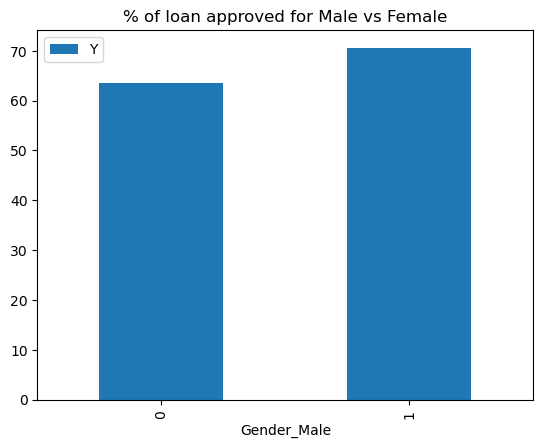

In [19]:
(pivot_sex['sum']/pivot_sex['count']*100).plot.bar(title='% of loan approved for Male vs Female')

<a id="2"></a>
# **<center><span style="color:#FF7B5F;">2. Evaluating unfairness</span></center>**

In [20]:
classifier = GradientBoostingClassifier()
classifier.fit(X, y)

y_pred = classifier.predict(X)

In [21]:
gm = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred, sensitive_features=gender_encoded)
print(gm.overall)
print(gm.by_group)

1.0
Gender_Male
0    1.0
1    1.0
Name: accuracy_score, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender_Male'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender_Male'>,
        <Axes: title={'center': 'recall'}, xlabel='Gender_Male'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Gender_Male'>,
        <Axes: xlabel='Gender_Male'>, <Axes: xlabel='Gender_Male'>],
       [<Axes: xlabel='Gender_Male'>, <Axes: xlabel='Gender_Male'>,
        <Axes: xlabel='Gender_Male'>]], dtype=object)

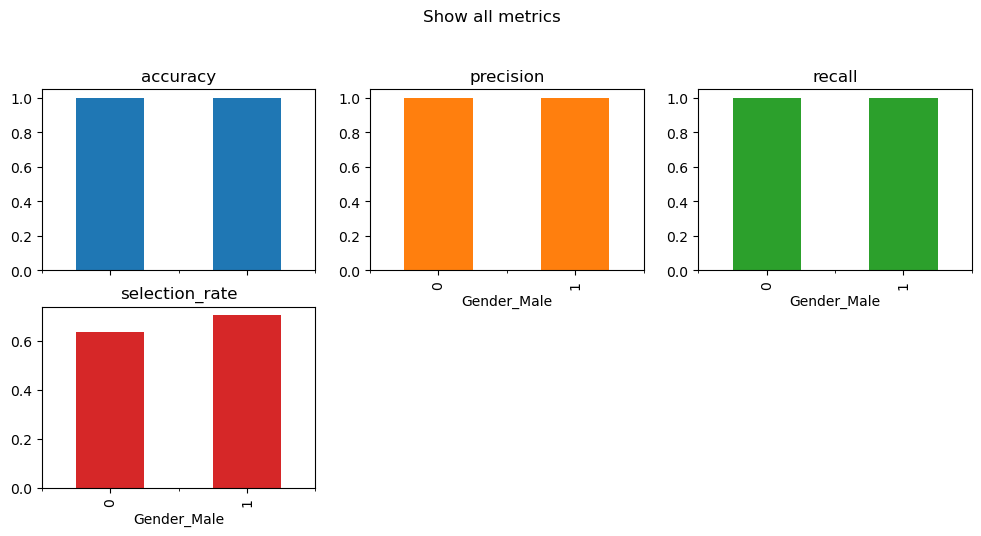

In [22]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred,
                           sensitive_features=dependents_encoded)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<a id="3"></a>
# **<center><span style="color:#FF7B5F;">3. Addressing unfairness for Gender</span></center>**

In [23]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y, sensitive_features=gender_encoded)
y_pred_mitigated = mitigator.predict(X)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y, y_pred=y_pred_mitigated, sensitive_features=gender_encoded)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.7013232514177694
Gender_Male
0    0.682243
1    0.706161
Name: selection_rate, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender_Male'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender_Male'>,
        <Axes: title={'center': 'recall'}, xlabel='Gender_Male'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='Gender_Male'>,
        <Axes: xlabel='Gender_Male'>, <Axes: xlabel='Gender_Male'>],
       [<Axes: xlabel='Gender_Male'>, <Axes: xlabel='Gender_Male'>,
        <Axes: xlabel='Gender_Male'>]], dtype=object)

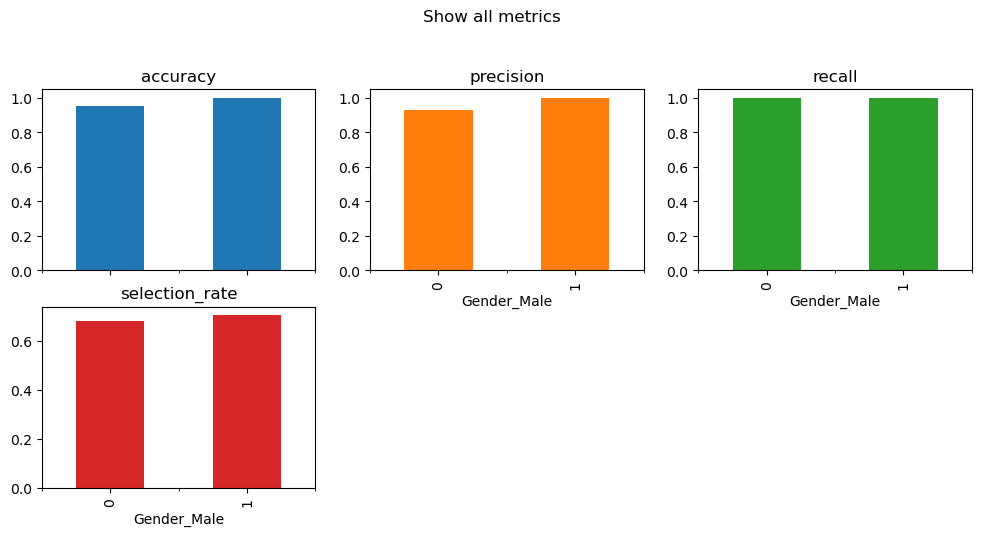

In [24]:
metric_frame_mitigated = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_mitigated,
                           sensitive_features=dependents_encoded)
metric_frame_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

<Axes: title={'center': 'Selection Rate split by dependents'}, xlabel='Gender_Male'>

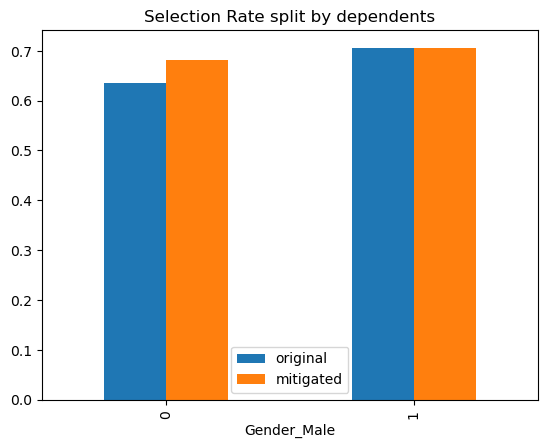

In [25]:
report = pd.DataFrame()
report['original'] = metric_frame.by_group['selection_rate']
report['mitigated'] = metric_frame_mitigated.by_group['selection_rate']
report.plot.bar(title='Selection Rate split by dependents')